## Super resolution

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'
path_bw = path/'small-bw-96'

In [3]:
il = ImageItemList.from_folder(path_hr)

In [4]:
def make_bw(fn,i):
    dest = path_bw/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.convert('1') # dither=PIL.Image.NONE
    img.save(dest)

In [5]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [23]:
# to create smaller images, uncomment the next line when you run this the first time
parallel(make_bw, il.items)

In [6]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_bw).random_split_by_pct(0.1, seed=42)

In [7]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [8]:
data = get_data(bs,size)

In [9]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [10]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
gram_matrix(t)

tensor([[[0.1345, 0.1321, 0.1172],
         [0.1321, 0.1300, 0.1155],
         [0.1172, 0.1155, 0.1033]],

        [[0.1345, 0.1321, 0.1172],
         [0.1321, 0.1300, 0.1155],
         [0.1172, 0.1155, 0.1033]]])

In [13]:
base_loss = F.l1_loss

In [14]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [15]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [17]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [18]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [38]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [19]:
lr = 1e-3

In [30]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(2, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [21]:
path_md = path/'small-96'/'models'
path_md.ls()

[PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-96/models/1a.pth'),
 PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-96/models/tmp.pth')]

In [22]:
learn.load('2b-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 334, 500), Image (3, 225, 300), Image (3, 334, 500), Image (3, 332, 500), Image (3, 500, 333)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-bw-96
x: ImageImageList (6651 items)
[Image (3, 334, 500), Image (3, 225, 300), Image (3, 334, 500), Image (3, 332, 500), Image (3, 500, 333)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-bw-96;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 300, 199), Image (3, 333, 500), Image (3, 466, 500), Image (3, 300, 248), Image (3, 188, 250)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-bw-96
x: ImageImageList (739 items)
[Image (3, 300, 199), Image (3, 333, 500), Image (3, 466, 500), Image (3, 300, 248), Image (3, 188, 250)]...
Path: /home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-bw-96;

Test: None, model=DynamicUnet(
  (layers): Modul

In [24]:
learn.unfreeze()

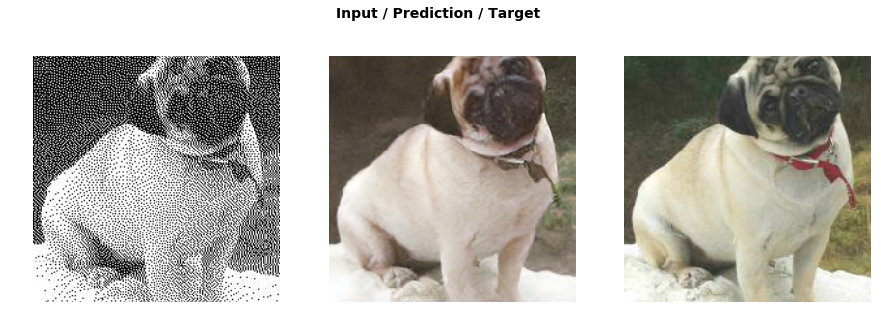

In [26]:
do_fit('1b', slice(1e-5,1e-3))

In [28]:
data = get_data(bs//2,size*2)
learn.data = data
learn.freeze()

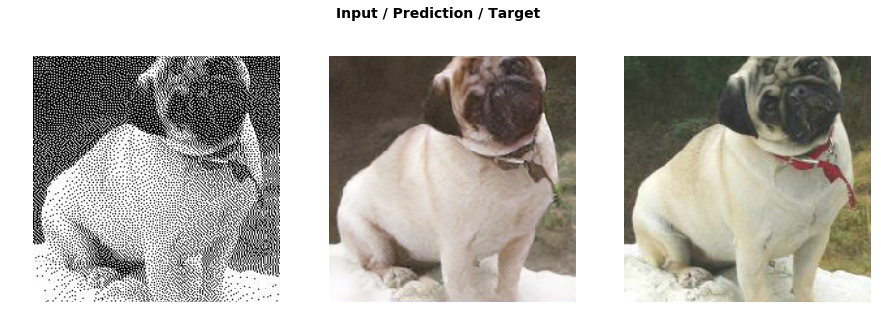

In [31]:
do_fit('2b-1-512')

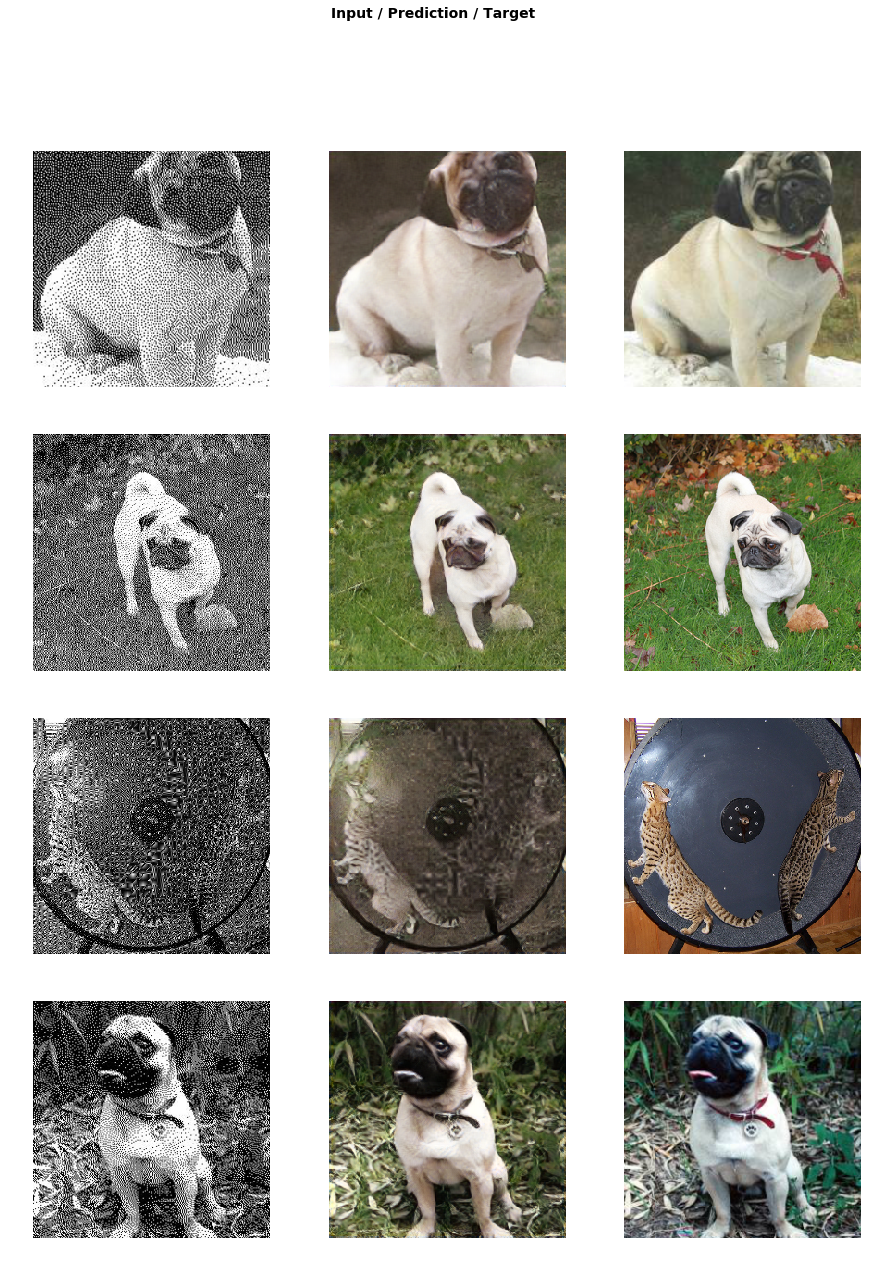

In [27]:
learn.show_results(rows=4, imgsize=5)

In [174]:
learn.save('2b-stop1')

In [25]:
learn.unfreeze()

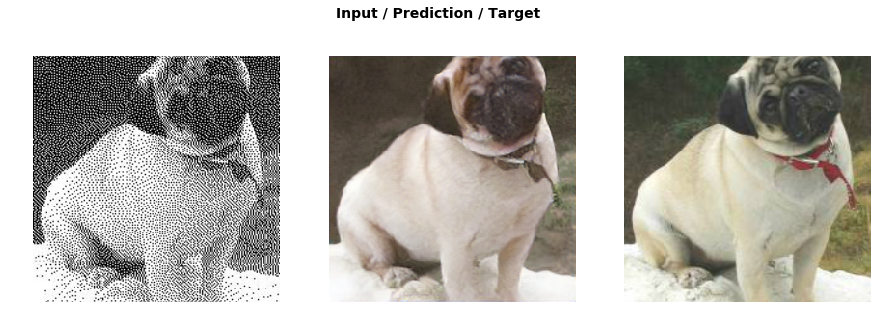

In [35]:
do_fit('2b-1', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [42]:
data_mr = (ImageImageList.from_folder(path_bw).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=1024, tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [43]:
learn.data = data_mr

In [44]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/home/nbuser/courses/fast-ai/course-v3/nbs/data/oxford-iiit-pet/small-bw-96/pug_133.jpg')

In [211]:
img = open_image(path/'qin10.jpg'); img.shape

torch.Size([3, 616, 988])

In [206]:
gc.collect()

2044

In [207]:
_,img_hr,b = learn.predict(img)

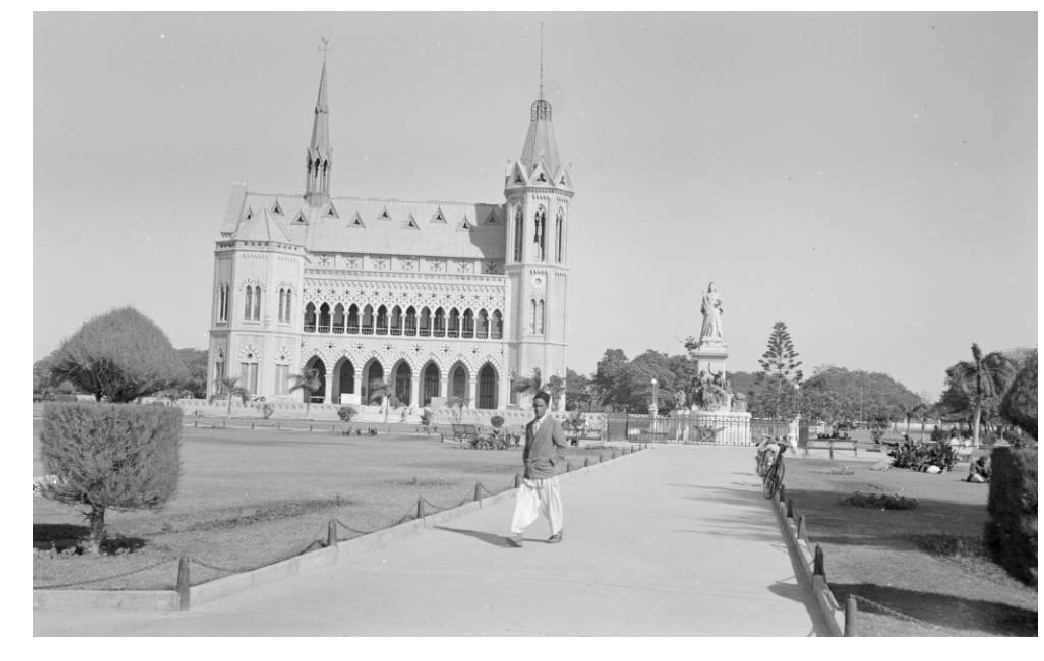

In [208]:
show_image(img, figsize=(18,15), interpolation='nearest')

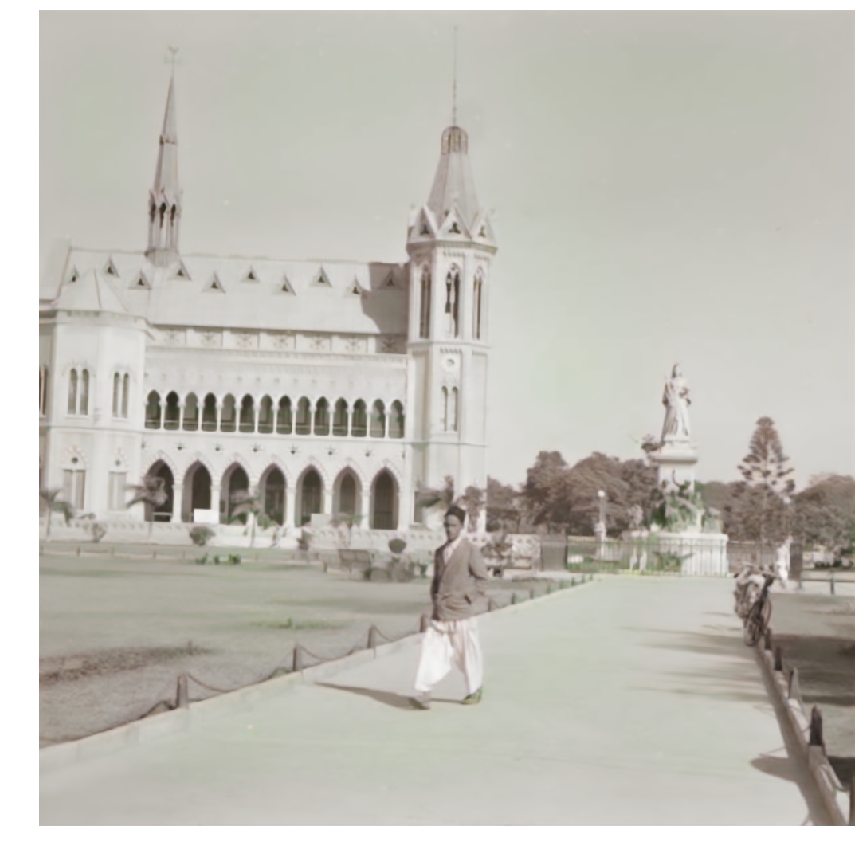

In [209]:
Image(img_hr).show(figsize=(18,15), interpolation='nearest')